# Petfinder.my competition: modelling, part one

## Introduction

## Libraries and misc function defs

In [3]:
import os
import itertools
from collections import Counter

import feather

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
def plot_average_confmatrix(model_results:dict, normalise:bool=True):
    mean_confmatrix = confusion_matrix(y_train, np.round(np.mean(model_results['lgb_preds'], axis=1)))
    if normalise:
        mean_confmatrix = mean_confmatrix.astype('float') / mean_confmatrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_confmatrix, annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if normalise:
        plt.title('Normalised confusion matrix')
    else:
        plt.title('Confusion matrix')
    plt.show()

## Loading data

In [36]:
INPUT_PATH = os.path.join(os.pardir, 'data', 'interim')

In [37]:
all_train = feather.read_dataframe(os.path.join(INPUT_PATH, 'train.feather'))
all_test = feather.read_dataframe(os.path.join(INPUT_PATH, 'test.feather'))

## Preparing data

Splits the training data into training and validation data sets. The size of the validation data was calculated to match the size of the final unseen testing data relative to the original training data.

In [38]:
cat_colnames = ['RescuerID', 'PetID', 'PrimaryLabel', 'SecondaryLabel']

In [39]:
# Dealing with categorical data
all_data = [all_train, all_test]

for df in all_data:
    for col in cat_colnames:
        df[col] = pd.Categorical(df[col])
        df[col] = df[col].cat.codes
        df[col] = pd.Categorical(df[col])

In [40]:
drop_cols = ['Name', 'Description', 'AdoptionSpeed']

In [41]:
X_train = all_train.drop(drop_cols, axis=1)
y_train = all_train['AdoptionSpeed']

In [8]:
# X_train, X_valid, y_train, y_valid = train_test_split(training_data, training_labels,
#                                                      test_size=len(all_test) / len(all_train))

In [9]:
print(X_train.shape, y_train.shape)

(14993, 346) (14993,)


## Model scoring metric

Competition submissions are evaluated in terms of the Quadratic Weighted Kappa (QWK; $\kappa$) score. This is a measure of agreement between predicted and actual classification labels with respect to a baseline agreement in which labels are considered to be randomly allocated. In this regard it is a more robust metric than a simple measure of accuracy as it tries to account for situations in which agreement between predicted and actual labels has arisen by chance.

The formula for calculating the QWK score is:

\begin{equation*}
\kappa = 1 - \frac{\sum_{ij}w_{ij}O_{ij}}{\sum_{ij}w_{ij}E_{ij}}
\end{equation*}

where:
- $O_{ij}$ is an $N\times N$ histogram matrix of observed values where $i$ is the actual label value and $j$ the predicted label. In other words, $O_{ij}$ equivalent to the confusion matrix.

- $E_{ij}$ is a $N\times N$ histogram matrix of the expected label values which assumes there is no correlation between the predicted and actual labels. This is the outer product between the histogram vectors of predicted and actual labels: $\frac{\sum_{i}O_{ij}\otimes\sum_{j}O_{ij}}{\sum (\sum_{i}O_{ij})}$ where $O_{ij}$ is the matrix of observed values.

- $w_{ij}$ is the quadratic weights matrix calculated from the difference between actual and predicted labels: $w_{ij} = \frac{(i - j)^2}{(N - 1)^2}$ where $i$ is the actual label value and $j$ the predicted label.

In [26]:
Oij = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
sum_actual = np.sum(Oij, axis=0)
sum_pred = np.sum(Oij, axis=1)
print(Oij)
print(sum_actual, sum_pred)
Eij = np.outer(sum_actual, sum_pred) / np.sum(sum_pred)
print(Eij)
print(np.sum(Oij))
print(np.sum(Eij))
print(np.sum(sum_actual + sum_pred))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[12 15 18] [ 6 15 24]
[[1.6 4.  6.4]
 [2.  5.  8. ]
 [2.4 6.  9.6]]
45
45.0
90


The QWK is a weighted variant of Cohen's kappa score which is implemented in the `metrics` module of scikit-learn:

In [11]:
def kappa_metric(predictions, actuals):
    return cohen_kappa_score(predictions, actuals, weights='quadratic')

## LightGBM: classification model

As a classification problem, I initially fitted a LightGBM classification model to the data with 5-fold cross-validation. As the model uses a softmax function, the predicted classification label was that with the highest probability.

### Model and CV functions

In [12]:
def lgb_model(train_data, train_labels, valid_data, valid_labels,
              model_params, scoring_metric, X_test=None):
    
    # Create training and validation lgb dataset objects
    lgb_X_train = lgb.Dataset(data=train_data, label=train_labels,
                              feature_name='auto', categorical_feature='auto',
                              free_raw_data=False)
    lgb_X_valid = lgb.Dataset(data=valid_data, label=valid_labels,
                              feature_name='auto', categorical_feature='auto',
                              free_raw_data=False)
    
    # Get parameters
    params2 = model_params.copy()
    num_iterations = params2.pop('num_iterations')
    early_stopping = params2.pop('early_stopping_rounds')
    verbose_eval = params2.pop('verbose_eval')
    
    # Train LightGBM model
    print("Training the LightGBM model...")
    model = lgb.train(params2,
                          lgb_X_train,
                          num_boost_round=num_iterations,
                          valid_sets=[lgb_X_train, lgb_X_valid],
                          early_stopping_rounds=early_stopping,
                          verbose_eval=verbose_eval)
    
    # Get model predictions on validation set
    print("Fitting the model to the validation data...")
    y_probs = model.predict(valid_data, num_iteration=model.best_iteration,
                           verbose_eval=verbose_eval) # Class probabilities from model
    
    
    y_preds = np.apply_along_axis(np.argmax, 1, y_probs) # Get label value according to highest probability
    qwk = scoring_metric(y_preds, valid_labels) # Compute kappa score
    conf_matrix = confusion_matrix(valid_labels, y_preds)
    importances = model.feature_importance() # Get feature importances
    
    print("-" * 40)
    print(f"Actual distribution of labels: {Counter(valid_labels)}")
    print(f"Predicted distribution of labels: {Counter(y_preds)}")
    print(f"CV split QWK score: {qwk}")
    print("Confusion matrix:\n", conf_matrix)
    print("-" * 40)
    
    return y_probs, y_preds, qwk, conf_matrix, importances

In [21]:
def cv_model(X:pd.DataFrame, y:list, nsplits:int, params):
    fold_counter = 1 #The current fold number
    skf = StratifiedKFold(n_splits=nsplits, shuffle=True)
    
    results = {
        "lgb_preds": np.zeros((X.shape[0], nsplits)),
        "lgb_pred_probs": [],
        "lgb_confusion_matrices": [],
        "lgb_qwk_scores": [],
        "feature_importances": pd.DataFrame()
    }
    
    for train_index, valid_index in skf.split(X, y):
        print(f"Fold {fold_counter} / {nsplits}:")
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Fit model
        y_probs, y_preds, qwk, conf_matrix, imps = lgb_model(X_train, y_train, X_valid, y_valid, params, kappa_metric)
        
        results["lgb_preds"][valid_index] = y_preds.reshape(-1, 1)
        results["lgb_pred_probs"].append(y_probs)
        results["lgb_qwk_scores"].append(qwk)
        results["lgb_confusion_matrices"].append(conf_matrix)
        
        fold_importances = pd.DataFrame()
        fold_importances['Features'] = X.columns.values
        fold_importances['Importance'] = imps
        fold_importances['FoldNum'] = fold_counter
        results["feature_importances"] = pd.concat([results["feature_importances"], fold_importances], axis=0)
        fold_counter += 1

    print("=" * 40)
    print(f"QWK scores: {results['lgb_qwk_scores']}")
    print(f"Mean QWK score: {np.mean(results['lgb_qwk_scores'])}")
    print(f"QWK score sd: {np.std(results['lgb_qwk_scores'])}")
    return results

### Fitting the initial model

After some experimentation, the hyperparameters below appear to produce the best performing model.

In [42]:
params = {'objective': 'softmax',
          'num_class': 5,
          'boosting': 'gbdt',
          'nthread': 4,
          'num_iterations': 10000,
          'learning_rate': 0.01,
          'num_leaves': 20,
          'max_depth': -1,
          'min_data_in_leaf': 120,
          'min_sum_hessian_in_leaf': 0.01,
          'bagging_fraction': 0.5,
          'bagging_frequency': 100,
          'feature_fraction': 0.5,
          'lambda_l2': 0.01,
          'min_gain_to_split': 0.0,
          'max_bin': 100,
          'early_stopping_rounds': 100,
          'data_random_seed': 42,
          'verbosity': -1,
          'verbose_eval': 100
         }

classification_model1_results = cv_model(X_train, y_train, 5, params)

Fold 1 / 5:
Training the LightGBM model...


/home/david/Envs/petfinder/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.32499	valid_1's multi_logloss: 1.38171
[200]	training's multi_logloss: 1.23381	valid_1's multi_logloss: 1.33923
[300]	training's multi_logloss: 1.16563	valid_1's multi_logloss: 1.31601
[400]	training's multi_logloss: 1.1089	valid_1's multi_logloss: 1.30088
[500]	training's multi_logloss: 1.06036	valid_1's multi_logloss: 1.29114
[600]	training's multi_logloss: 1.017	valid_1's multi_logloss: 1.28478
[700]	training's multi_logloss: 0.978017	valid_1's multi_logloss: 1.28029
[800]	training's multi_logloss: 0.941977	valid_1's multi_logloss: 1.27719
[900]	training's multi_logloss: 0.908157	valid_1's multi_logloss: 1.27498
[1000]	training's multi_logloss: 0.876705	valid_1's multi_logloss: 1.27321
[1100]	training's multi_logloss: 0.847157	valid_1's multi_logloss: 1.27222
[1200]	training's multi_logloss: 0.819362	valid_1's multi_logloss: 1.27152
[1300]	training's multi_logloss: 0.792976	valid_1's mul

Fitting the model to the validation data...
----------------------------------------
Actual distribution of labels: Counter({4: 839, 2: 807, 3: 651, 1: 618, 0: 82})
Predicted distribution of labels: Counter({4: 1202, 2: 822, 1: 551, 3: 413, 0: 9})
CV split QWK score: 0.39136815559980154
Confusion matrix:
 [[  8  22  21   8  23]
 [  1 232 179  65 141]
 [  0 150 307 133 217]
 [  0  98 200 161 192]
 [  0  49 115  46 629]]
----------------------------------------
QWK scores: [0.39867194188010446, 0.3954760950067223, 0.397382502830255, 0.4020384635943127, 0.39136815559980154]
Mean QWK score: 0.3969874317822392
QWK score sd: 0.003531769568726421


The model is overfitting somewhat, even after altering the hyperparameters (as outlined in the [LightGBM docs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)) to try to reduce this.

### Feature importances

In many other situations, a reduction in the dimensionality of a random forest model by removing less important features has been found to improve the overall accuracy of the model. Here, features with a mean importance score lower than the median importance were dropped from the training data.

In [43]:
mean_importances = classification_model1_results['feature_importances'].groupby('Features')["Features", "Importance"]\
                                        .mean().reset_index()\
                                        .sort_values('Importance', ascending=False)

In [44]:
mean_importances

,Features,Importance
29,RescuerID,7453.2
0,Age,1805.0
3,Breed1,1631.0
26,PrimaryLabelScore,1158.2
20,PhotoAmt,1112.4
35,SecondaryLabelScore,941.4
34,SecondaryLabel,915.6
8,CropBoxArea,885.0
42,TopRightY,763.4
40,Sterilized,682.0


In [45]:
mean_importances.describe()

,Importance
count,346.000000
mean,385.985549
std,414.384151
min,0.000000
25%,300.800000
50%,353.200000
75%,406.900000
max,7453.200000


In [46]:
drop_features = list(mean_importances['Features'][mean_importances['Importance'] < 
                                                       mean_importances['Importance'].median()])

Features which had importances below the median importance were dropped from the training data.

In [47]:
X_train_reduced = X_train.drop(drop_features, axis=1)

### Fitting the lower dimension model

In [48]:
params = {'objective': 'softmax',
          'num_class': 5,
          'boosting': 'gbdt',
          'nthread': 4,
          'num_iterations': 10000,
          'learning_rate': 0.01,
          'num_leaves': 40,
          'max_depth': -1,
          'min_data_in_leaf': 240,
          'min_sum_hessian_in_leaf': 0.005,
          'bagging_fraction': 0.5,
          'bagging_frequency': 100,
          'feature_fraction': 0.5,
          'lambda_l2': 0.01,
          'min_gain_to_split': 0.0,
          'max_bin': 100,
          'early_stopping_rounds': 100,
          'data_random_seed': 42,
          'verbosity': -1,
          'verbose_eval': 100
         }

classification_model2_results = cv_model(X_train_reduced, y_train, 5, params)

Fold 1 / 5:
Training the LightGBM model...


/home/david/Envs/petfinder/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.31334	valid_1's multi_logloss: 1.37301
[200]	training's multi_logloss: 1.20803	valid_1's multi_logloss: 1.32322
[300]	training's multi_logloss: 1.12533	valid_1's multi_logloss: 1.29416
[400]	training's multi_logloss: 1.05562	valid_1's multi_logloss: 1.27477
[500]	training's multi_logloss: 0.993764	valid_1's multi_logloss: 1.26147
[600]	training's multi_logloss: 0.938158	valid_1's multi_logloss: 1.25249
[700]	training's multi_logloss: 0.887271	valid_1's multi_logloss: 1.24585
[800]	training's multi_logloss: 0.840571	valid_1's multi_logloss: 1.24104
[900]	training's multi_logloss: 0.797584	valid_1's multi_logloss: 1.23781
[1000]	training's multi_logloss: 0.757445	valid_1's multi_logloss: 1.23536
[1100]	training's multi_logloss: 0.720119	valid_1's multi_logloss: 1.23373
[1200]	training's multi_logloss: 0.685024	valid_1's multi_logloss: 1.23293
[1300]	training's multi_logloss: 0.652251	valid_1'

### Model analysis and discussion

At least insofar as concerns the Kaggle competition public leaderboard, the initial models perform somewhat poorly. The multi-logloss results for each fold suggest the model is overfitting, but attempts to resolve by e.g. decreasing the `num_leaves` and `max_bin` hyperparameters did not consistently improve the QWK score within folds, nor the mean QWK score. Reducing the number of features also had minimal impact on the QWK score.

In [53]:
print(f"Actual distribution of categories: {Counter(y_train)}")
print(f"Predicted distribution of categories: {Counter(np.round(np.mean(classification_model2_results['lgb_preds'],axis=1)))}")
# For some reason they're are out of order. I have no idea why...

Actual distribution of categories: Counter({4: 4197, 2: 4037, 3: 3259, 1: 3090, 0: 410})
Predicted distribution of categories: Counter({4.0: 5901, 2.0: 4031, 1.0: 2904, 3.0: 2116, 0.0: 41})


Regardless of hyperparameter values, the models made similar classification errors. In terms of classification label distributions (above), the final model still struggles to accurately predict 0s and has a clear tendency to overpredict 4s. The former is likely caused by a relative lack of training examples and few strong predictors of class 0 in the feature set as discussed in the EDA notebook.

Below is the confusion matrix for all folds in the final model.

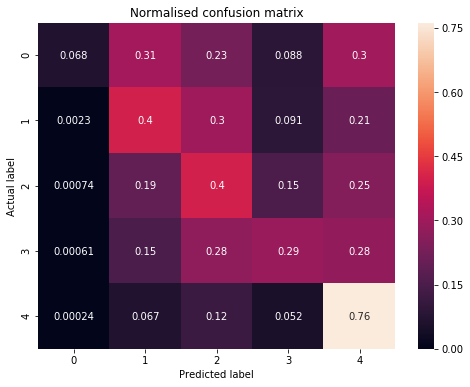

In [57]:
plot_average_confmatrix(classification_model2_results)

There are some interesting patterns here (the exact values will vary a little):
- Only 5.6% of actual 0s are accurately classified. Of those that are misclassified, 33% are wrongly considered category 4, with the almost all the rest split somewhat between 1, 2 and 4.
- 37% of 1s are correctly classified. However, 30% are misclassified as 2s and a further 26% as 4s.
- 28% of 3s are correct, with 30% wrong classified as 2s and 29% as 4s.

This suggests that some form of redistributing the classifications might improve the overall accuracy (and, more importantly, QWK score) of the model. Luckily, some Kaggle users with more knowledge/experience than me have already gone down this route. What follows in the next section is an implementation of what appears to currently be the most popular solution.

## LightGBM: regression model

In the previous section I fitted a LightGBM classification model to the training data. This did not perform as well as hoped, seemingly regardless of hyperparameter values, with an average overall QWK score of between about 0.399 and 0.400. An approach currently being experimented with on Kaggle for this particular competition (starting, I believe, in [this kernel](https://www.kaggle.com/abhishek/maybe-something-interesting-here) by Abhishek) is to fit a regression model to the data then bin the continuous predictions (0 to +inf) into the required categorical predictions (0 to 4). By adjusting the thresholds for each bin, the overall accuracy/QWK score of the model can be improved beyond what could be achieved by the earlier classification model.

### The 'Optimized Rounder'

The key to the success of the binning of the continuous prediction values is the selection of optimal threshold values. In the aforementioned kernel, this is done by minimizing a loss function, in this case the (negative) QWK score.

The `OptimizedRounder` has three parts:
1. Initial coefficient (threshold) values are chosen
2. The QWK loss function is minimized using the Nelder-Mead algorithm
3. The optimized coefficient values are used to bin the validation/testing data

In [ ]:
class OptimizedRounder(object):
    """
    From https://www.kaggle.com/abhishek/maybe-something-interesting-here
    I have added some comments for documentation/explanation
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
